In [1]:
import numpy as np
import matplotlib as mpl
import pandas as pd
from sklearn.cross_decomposition import CCA
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
import pickle
from tqdm.auto import tqdm
import seaborn as sns

mpl.rcdefaults()
mpl_config = pd.read_csv('mpl_config.csv').to_dict(orient='records')[0]
mpl.rcParams.update(mpl_config)

## Cross-correlation

### Data import

In [2]:
with open("Save/hercule_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/hercule_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)

"""
with open("Save/h&n_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/h&n_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)
"""

with open("Save/hercule_pmc", "rb") as fp:
     n_data_pmc_s = pickle.load(fp)

with open("Save/hercule_pmc_features", "rb") as fp:
     f_data_pmc_s = pickle.load(fp)


### Raw correlations

In [273]:
def extract_cuts(index_list, data_array, min_length=1000):
    """
    Extracts cuts from a 2D array based on regions where values in the index_list
    are consistently 0 or 1 for more than min_length points.

    Parameters:
    - index_list: List[int] with values -1, 0, 1.
    - data_array: np.ndarray, 2D array with shape (N, M), M == len(index_list).
    - min_length: int, minimum length for a segment to be considered a valid cut.

    Returns:
    - cuts_0: List of np.ndarrays where index == 0 for > min_length.
    - cuts_1: List of np.ndarrays where index == 1 for > min_length.
    """
    index_array = np.array(index_list)
    assert data_array.shape[1] == len(index_list), "Data column count must match index list length."

    cuts_0 = []
    cuts_1 = []

    current_val = None
    start_idx = 0

    for i, val in enumerate(index_array):
        if val != current_val:
            if current_val in (0, 1):
                segment_length = i - start_idx
                if segment_length > min_length:
                    segment = data_array[:, start_idx:i]
                    if current_val == 0:
                        cuts_0.append(segment)
                    elif current_val == 1:
                        cuts_1.append(segment)
            start_idx = i
            current_val = val

    # Handle last segment
    if current_val in (0, 1):
        segment_length = len(index_array) - start_idx
        if segment_length > min_length:
            segment = data_array[:, start_idx:]
            if current_val == 0:
                cuts_0.append(segment)
            elif current_val == 1:
                cuts_1.append(segment)

    return [cuts_0, cuts_1]

cond_slice_a1 = [extract_cuts(f_data_s[i]['Condition'].to_numpy(),n_data_a1_s[i]) for i in range(len(f_data_s))]
cond_slice_pmc = [extract_cuts(f_data_pmc_s[i]['Condition'].to_numpy(),n_data_pmc_s[i]) for i in range(len(f_data_s))]

In [274]:
def pairwise_correlations(array1, array2):
    """
    Compute all pairwise Pearson correlations between neurons in two 2D arrays.

    Parameters:
    - array1: np.ndarray of shape (N1, T) where N1 is number of neurons, T is number of time points
    - array2: np.ndarray of shape (N2, T)

    Returns:
    - correlation_matrix: np.ndarray of shape (N1, N2) with correlation coefficients
    """
    if not array1.shape[1] == array2.shape[1] :
        print("Slightly different shape truncating to match time points..  /n Array 1 shape: " + str(array1.shape[1]) + '//' + 'Array 2 shape: ' + str(array2.shape[1]))
        min_shape = np.minimum(array1.shape[1],array2.shape[1])
        array1 = array1[:,:min_shape]
        array2 = array2[:,:min_shape]
    # Normalize both arrays (zero mean, unit variance)
    a1 = (array1 - array1.mean(axis=1, keepdims=True)) / array1.std(axis=1, keepdims=True)
    a2 = (array2 - array2.mean(axis=1, keepdims=True)) / array2.std(axis=1, keepdims=True)

    # Compute correlation matrix using matrix multiplication
    correlation_matrix = np.dot(a1, a2.T) / array1.shape[1]

    return np.nan_to_num(correlation_matrix)


corr_tracking = []
corr_playback = []
for session_id in range(len(cond_slice_a1)) :
    tracking_a1 = cond_slice_a1[session_id][0]
    tracking_pmc = cond_slice_pmc[session_id][0]

    playback_a1 = cond_slice_a1[session_id][1]
    playback_pmc = cond_slice_pmc[session_id][1]

    for i in range(len(tracking_a1)) :
        corr_tracking.append(pairwise_correlations(tracking_a1[i],tracking_pmc[i]).flatten())
        
    for i in range(len(playback_a1)) :
        corr_playback.append(pairwise_correlations(playback_a1[i],playback_pmc[i]).flatten())

Slightly different shape truncating to match time points..  /n Array 1 shape: 339355//Array 2 shape: 339356
Slightly different shape truncating to match time points..  /n Array 1 shape: 249089//Array 2 shape: 250781
Slightly different shape truncating to match time points..  /n Array 1 shape: 298730//Array 2 shape: 298729
Slightly different shape truncating to match time points..  /n Array 1 shape: 60061//Array 2 shape: 60062
Slightly different shape truncating to match time points..  /n Array 1 shape: 59880//Array 2 shape: 59879


/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/823023146.py:21: RuntimeWarning: invalid value encountered in divide
  a2 = (array2 - array2.mean(axis=1, keepdims=True)) / array2.std(axis=1, keepdims=True)


/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_12173/2767500610.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(df_plot[::20], x='Condition',y='Correlation', palette=['#FF495C','#546460'],size=6,alpha=0.5)


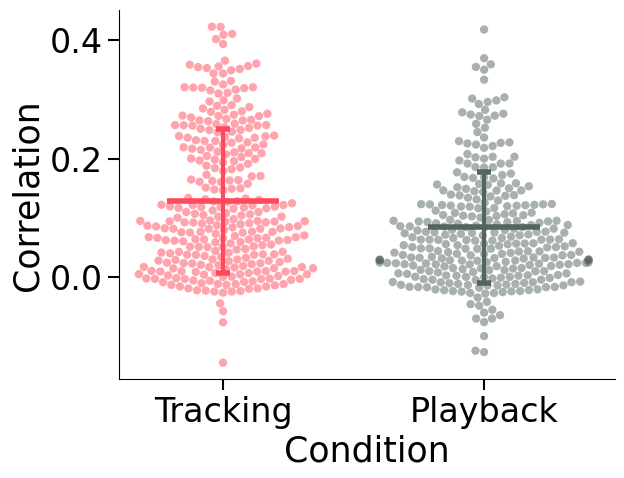

In [443]:
"""
mean_corr_track = [np.mean(corr_tracking[i]) for i in range(len(corr_tracking))]
mean_corr_pb = [np.mean(corr_playback[i]) for i in range(len(corr_playback))]
"""

mean_corr_track = np.concatenate(corr_tracking)
mean_corr_pb = np.concatenate(corr_playback)

df_plot = pd.DataFrame({'Correlation':np.concatenate((mean_corr_track,mean_corr_pb)), \
'Condition':['Tracking']*len(mean_corr_track)+['Playback']*len(mean_corr_pb)})

#sns.violinplot(df_plot, x='Condition',y='Correlation', palette=['#FF495C','#546460'],inner_kws={'box_width':15},cut=3,bw_adjust=1)
sns.swarmplot(df_plot[::20], x='Condition',y='Correlation', palette=['#FF495C','#546460'],size=6,alpha=0.5)
plt.errorbar(0,np.mean(mean_corr_track),yerr=np.std(mean_corr_track),marker='_',markersize=80,markeredgewidth=4,linewidth=3,color='#FF495C')
plt.errorbar(1,np.mean(mean_corr_pb),yerr=np.std(mean_corr_pb),marker='_',markersize=80,markeredgewidth=4,linewidth=3,color='#546460')
plt.xlim((-0.4,1.5))

plt.savefig('Plots/SVG/pairwise_corr.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/pairwise_corr.PNG', dpi = 300,bbox_inches='tight')

In [314]:
from scipy.stats import mannwhitneyu

mannwhitneyu(mean_corr_track, mean_corr_pb)

MannwhitneyuResult(statistic=284.0, pvalue=0.023903145867558408)

In [93]:
import pandas as pd
import seaborn as sns

corr_early = np.concatenate(corr_tracking[:6])
corr_mid = np.concatenate(corr_tracking[6:12])
corr_late = np.concatenate(corr_tracking[12:])
corr_pb = np.concatenate(corr_playback[:])

df_plot = pd.DataFrame({'Correlation':np.concatenate((corr_pb,corr_early,corr_mid,corr_late)), \
'Condition':['Playback']*len(corr_pb)+['Early']*len(corr_early)+['Mid']*len(corr_mid)+['Late']*len(corr_late)})

sns.violinplot(df_plot, x='Condition',y='Correlation', palette=['#546460','#F0A202','#D95D39','#FF495C'],inner_kws={'box_width':15},cut=3,bw_adjust=1)
#plt.plot([np.mean(corr_tracking[i]) for i in range(len(corr_tracking))])
#plt.plot([np.mean(corr_playback[i]) for i in range(len(corr_playback))])

ValueError: need at least one array to concatenate

### Correcting for inter-condition variance

In [365]:
def get_event_vicinity(bool_array, window_size=100):
    """
    Return a 2D array of indices around True values in a boolean array,
    skipping events that overlap more than 50% with previous ones.

    Parameters:
        bool_array (np.ndarray): 1D boolean array.
        window_size (int): Number of indices before and after each True value.

    Returns:
        np.ndarray: 2D array of index windows, one per event.
    """
    event_indices = np.where(bool_array)[0]
    total_len = len(bool_array)
    full_window_size = window_size 
    last_window_end = -np.inf
    result = []

    for idx in event_indices:
        start = max(0, idx - int(window_size/3))
        end = min(total_len, idx + int(2*window_size/3)+ 1)
        indices = np.arange(start, end)

        # Pad if at edge
        if len(indices) < window_size:
            pad_len = full_window_size - len(indices)
            indices = np.pad(indices, (0, pad_len), mode='constant', constant_values=-1)

        # Check for overlap with previous event
        if start < last_window_end:
            overlap = last_window_end - start
            if overlap > 0: # window_size//5:
                continue  # Too much overlap, skip this event

        result.append(indices)
        last_window_end = end  # update end of last accepted window

    return np.array(result)

def get_events(n_data, triggers, freq, mock, w_size):
    """Return freq, mock, and stacked neural data for given triggers."""
    event_idx = get_event_vicinity(triggers, w_size)
    freq_vals = freq[event_idx[:, -1]]
    mock_vals = mock[event_idx[:, -1]]
    stacked = np.stack([n_data[:, idx] for idx in event_idx])
    return freq_vals, mock_vals, stacked

In [366]:
w_size_cca = 100
fmin, fmax = 600, 6000

def slice_data(n_data_sessions, f_data_sessions):
    Xs, Ys = [], []
    
    for n_data, f_data in zip(n_data_sessions, f_data_sessions):
        freq        = f_data['Played_frequency'].to_numpy()
        mock        = f_data['Mock_frequency'].to_numpy()
        direc       = f_data['Change_direction'].to_numpy()
        direc_mock  = f_data['Mock_direction'].to_numpy()
        triggers    = np.copy(f_data['Frequency_changes'].to_numpy())
        triggers_mk = np.copy(f_data['Mock_change'].to_numpy())
        condition   = f_data['Condition'].to_numpy()

        # Apply frequency bounds
        triggers    = triggers * ((freq >= fmin) & (freq <= fmax))
        triggers_mk = triggers_mk * ((mock >= fmin) & (mock <= fmax))

        # Define trigger conditions
        trigger_map = [
            ("track_p", triggers    * (condition == 0) * (direc ==  1), 1, 1, 0),
            ("track_m", triggers    * (condition == 0) * (direc == -1),-1,-1,0),
            ("pb_p",    triggers    * (condition == 1) * (direc ==  1), 1, 0, 1),
            ("pb_m",    triggers    * (condition == 1) * (direc == -1),-1, 0, 1),
            ("pb_mk_p", triggers_mk * (condition == 1) * (direc_mock ==  1),0, 1, 1),
            ("pb_mk_m", triggers_mk * (condition == 1) * (direc_mock == -1),0,-1,1),
        ]

        all_freq, all_mock, all_data = [], [], []
        Fchange_labels, Mchange_labels, cond_labels = [], [], []

        for _, trig, Fchg, Mchg, cond in trigger_map:
            f_vals, m_vals, data = get_events(n_data, trig, freq, mock, w_size_cca)
            all_freq.append(f_vals)
            all_mock.append(m_vals)
            all_data.append(data)
            Fchange_labels.append(np.full(len(f_vals), Fchg))
            Mchange_labels.append(np.full(len(f_vals), Mchg))
            cond_labels.append(np.full(len(f_vals), cond))

        # Combine
        Xs.append(np.concatenate(all_data, axis=0))
        freq_label  = np.concatenate(all_freq)
        mock_label  = np.concatenate(all_mock)
        Fchange_lab = np.concatenate(Fchange_labels)
        Mchange_lab = np.concatenate(Mchange_labels)
        cond_lab    = np.concatenate(cond_labels)

        Ys.append(np.stack((freq_label, mock_label, Fchange_lab, Mchange_lab, cond_lab), axis=1))

    return Xs, Ys

# Run
Xs_a1,  Ys_a1  = slice_data(n_data_a1_s,  f_data_a1_s) 
Xs_pmc, Ys_pmc = slice_data(n_data_pmc_s, f_data_a1_s)

In [367]:
def remove_intercondition_var(M, F):
    """Group trials by context and specific features, remove average activity per condition to only keep temporal variations."""
    M, F = np.asarray(M), np.asarray(F)
    if M.shape[0] != F.shape[0]:
        raise ValueError("M and F must have the same number of trials.")
    
    context = F[:, 4]
    grouping_rules = [
        (context == 0, [0, 2]),      # freq & freq_change
        (context == 1, [0, 2]),      # freq & freq_change
        (context == 1, [1, 3]),      # mock & mock_change
    ]
    
    all_keys, all_idx = [], []
    for mask, cols in grouping_rules:
        all_keys.append(np.stack([context[mask], *[F[mask, c] for c in cols]], axis=1))
        all_idx.append(np.nonzero(mask)[0])
    
    all_keys = np.vstack(all_keys)
    all_idx = np.concatenate(all_idx)

    unique_keys, inv = np.unique(all_keys, axis=0, return_inverse=True)
    M_correct = np.zeros_like(M)
    for i in range(len(unique_keys)):
        trials = M[all_idx[inv == i]]
        M_correct[all_idx[inv == i]] = M[all_idx[inv == i]] - trials.mean(axis=(0,2),keepdims=True)

    return M_correct


M_corr_a1 = [remove_intercondition_var(Xs_a1[i], Ys_a1[i]) for i in range(len(Xs_a1))]
M_corr_pmc = [remove_intercondition_var(Xs_pmc[i], Ys_pmc[i]) for i in range(len(Xs_pmc))]

In [439]:
def pairwise_correlations(array1, array2):
    """
    Compute all pairwise Pearson correlations between neurons in two 2D arrays.

    Parameters:
    - array1: np.ndarray of shape (N1, T) where N1 is number of neurons, T is number of time points
    - array2: np.ndarray of shape (N2, T)

    Returns:
    - correlation_matrix: np.ndarray of shape (N1, N2) with correlation coefficients
    """
    if not array1.shape[1] == array2.shape[1] :
        print("Slightly different shape truncating to match time points..  /n Array 1 shape: " + str(array1.shape[1]) + '//' + 'Array 2 shape: ' + str(array2.shape[1]))
        min_shape = np.minimum(array1.shape[1],array2.shape[1])
        array1 = array1[:,:min_shape]
        array2 = array2[:,:min_shape]
    # Normalize both arrays (zero mean, unit variance)
    a1 = (array1 - array1.mean(axis=1, keepdims=True)) / array1.std(axis=1, keepdims=True)
    a2 = (array2 - array2.mean(axis=1, keepdims=True)) / array2.std(axis=1, keepdims=True)

    # Compute correlation matrix using matrix multiplication
    correlation_matrix = np.dot(a1, a2.T) / array1.shape[1]

    return np.nan_to_num(correlation_matrix)

corr_type = 'Total'

corr_tracking = []
corr_playback = []
for session_id in range(len(M_corr_a1)) :
    track_idx = Ys_a1[session_id][:,4] == 0
    pb_idx = Ys_a1[session_id][:,4] == 1
    
    tracking_a1 = M_corr_a1[session_id][track_idx]
    tracking_pmc =  M_corr_pmc[session_id][track_idx]

    playback_a1 = M_corr_a1[session_id][pb_idx]
    playback_pmc =  M_corr_pmc[session_id][pb_idx]

    if corr_type == 'Total' :
        tracking_a1 = tracking_a1.reshape(tracking_a1.shape[1],tracking_a1.shape[0]*tracking_a1.shape[2])
        tracking_pmc = tracking_pmc.reshape(tracking_pmc.shape[1],tracking_pmc.shape[0]*tracking_pmc.shape[2])
    
        playback_a1 = playback_a1.reshape(playback_a1.shape[1],playback_a1.shape[0]*playback_a1.shape[2])
        playback_pmc = playback_pmc.reshape(playback_pmc.shape[1],playback_pmc.shape[0]*playback_pmc.shape[2])
    
        corr_tracking.append(np.abs(pairwise_correlations(tracking_a1,tracking_pmc).flatten()))
        corr_playback.append(np.abs(pairwise_correlations(playback_a1,playback_pmc).flatten()))
    
    elif corr_type == 'Trial' :
        corr_track_trial = []
        corr_playback_trial = []
        for i in range(len(tracking_a1)) :
            corr_track_trial.append(np.abs(pairwise_correlations(tracking_a1[i],tracking_pmc[i]).flatten()))
            corr_playback_trial.append(np.abs(pairwise_correlations(playback_a1[i],playback_pmc[i]).flatten()))
        
        corr_tracking.append(np.mean(np.array(corr_track_trial),axis=0))
        corr_playback.append(np.mean(np.array(corr_playback_trial),axis=0))


def top_percent(arr,percent=20,axis=None) : 
    threshold = np.percentile(arr, 100 - percent, axis=axis, keepdims=True)
    mask = arr >= threshold
    return arr[mask]


top_neurons = True

if top_neurons :
    for i in range(len(corr_tracking)):
        corr_tracking[i] = top_percent(corr_tracking[i])
        corr_playback[i] = top_percent(corr_playback[i])
    

/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_62679/3546816685.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(df_plot[:], x='Condition',y='Correlation', palette=['#FF495C','#546460'],size=4,alpha=0.5)


(-0.4, 1.5)

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 15.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


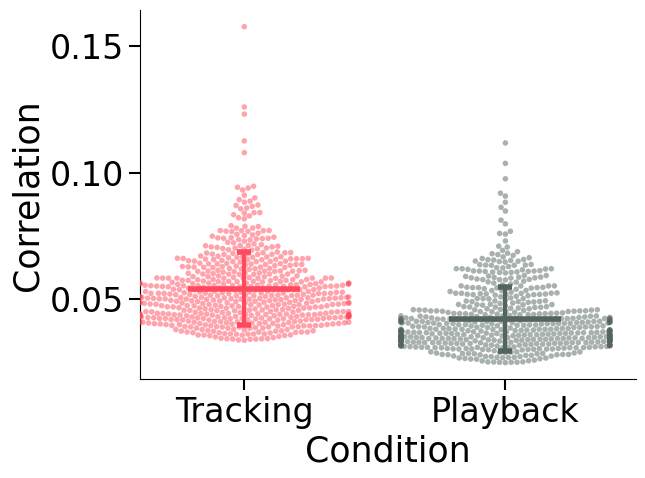

In [445]:
"""
mean_corr_track = [np.mean(corr_tracking[i]) for i in range(len(corr_tracking))]
mean_corr_pb = [np.mean(corr_playback[i]) for i in range(len(corr_playback))]
"""

mean_corr_track = np.concatenate(corr_tracking)
mean_corr_pb = np.concatenate(corr_playback)

df_plot = pd.DataFrame({'Correlation':np.concatenate((mean_corr_track,mean_corr_pb)), \
'Condition':['Tracking']*len(mean_corr_track)+['Playback']*len(mean_corr_pb)})

#sns.violinplot(df_plot, x='Condition',y='Correlation', palette=['#FF495C','#546460'],inner_kws={'box_width':15},cut=3,bw_adjust=1)
sns.swarmplot(df_plot[:], x='Condition',y='Correlation', palette=['#FF495C','#546460'],size=4,alpha=0.5)
plt.errorbar(0,np.mean(mean_corr_track),yerr=np.std(mean_corr_track),marker='_',markersize=80,markeredgewidth=4,linewidth=3,color='#FF495C')
plt.errorbar(1,np.mean(mean_corr_pb),yerr=np.std(mean_corr_pb),marker='_',markersize=80,markeredgewidth=4,linewidth=3,color='#546460')
plt.xlim((-0.4,1.5))

#plt.savefig('Plots/SVG/pairwise_corr.svg', dpi = 300,bbox_inches='tight')
#plt.savefig('Plots/PNG/pairwise_corr.PNG', dpi = 300,bbox_inches='tight')

In [435]:
print(np.mean(mean_corr_track))
print(np.mean(mean_corr_pb))
print(mannwhitneyu(mean_corr_track,mean_corr_pb))


0.0633250784178506
0.05049146999854013
MannwhitneyuResult(statistic=61347.0, pvalue=5.132471725783471e-32)


/var/folders/fd/x7ht4zdn0yz2xb9997swqj0r0000gn/T/ipykernel_62679/3180634875.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_plot, x='Condition',y='Abs. correlation', palette=['#546460','#FD9797','#FD5656','#DD3030'],cut=3,inner_kws={'box_width':15},bw_adjust=1)


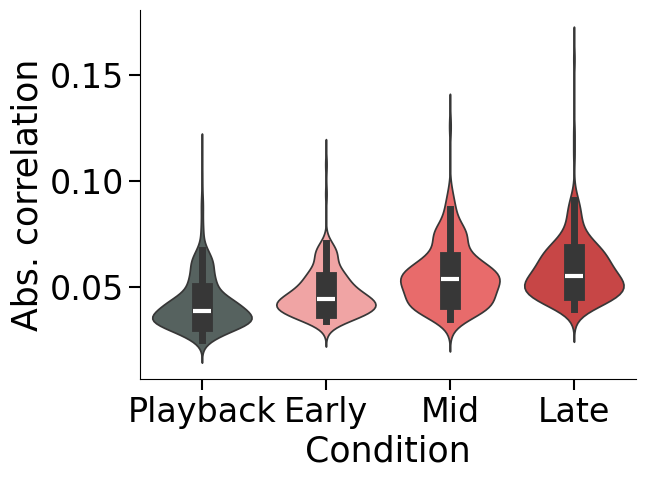

In [489]:
import pandas as pd
import seaborn as sns



corr_early = np.abs(np.concatenate(corr_tracking[:3]))
corr_mid = np.abs(np.concatenate(corr_tracking[3:8]))
corr_late = np.abs(np.concatenate(corr_tracking[8:]))
corr_pb = np.abs(np.concatenate(corr_playback[:]))

#corr_early = np.abs(np.concatenate(corr_playback[:3]))
#corr_mid = np.abs(np.concatenate(corr_playback[3:6]))
#corr_late = np.abs(np.concatenate(corr_playback[6:]))


df_plot = pd.DataFrame({'Abs. correlation':np.concatenate((corr_pb,corr_early,corr_mid,corr_late)), \
'Condition':['Playback']*len(corr_pb)+['Early']*len(corr_early)+['Mid']*len(corr_mid)+['Late']*len(corr_late)})

sns.violinplot(df_plot, x='Condition',y='Abs. correlation', palette=['#546460','#FD9797','#FD5656','#DD3030'],cut=3,inner_kws={'box_width':15},bw_adjust=1)

plt.savefig('Plots/SVG/pairwisecorr_violin.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/pairwisecorr_violin.PNG', dpi = 300,bbox_inches='tight')

In [442]:
from scipy.stats import mannwhitneyu
print(np.mean(corr_pb))
print(np.mean(corr_early))
print(np.mean(corr_mid))
print(np.mean(corr_late))
print(mannwhitneyu(corr_pb,corr_early))
print(mannwhitneyu(corr_pb,corr_late))
print(mannwhitneyu(corr_early,corr_late))
print(mannwhitneyu(corr_mid,corr_late))

0.042275007435033575
0.04736608351041597
0.05540243530615232
0.05852683371324535
MannwhitneyuResult(statistic=30699.0, pvalue=2.2683949715893052e-11)
MannwhitneyuResult(statistic=18768.0, pvalue=3.6035929900943624e-48)
MannwhitneyuResult(statistic=8340.0, pvalue=5.431196181335477e-19)
MannwhitneyuResult(statistic=15872.0, pvalue=0.01839108234813087)


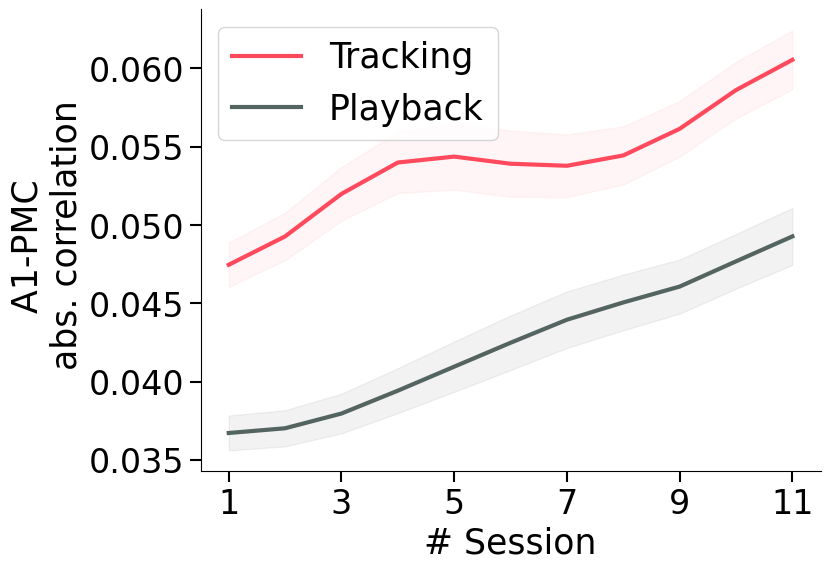

In [488]:
from scipy.ndimage import gaussian_filter

corr_track_t = np.array([np.mean(corr_tracking[i]) for i in range(len(corr_tracking))])
corr_pb_t = np.array([np.mean(corr_playback[i]) for i in range(len(corr_playback))])
corr_track_std = np.array([np.std(corr_tracking[i])/np.sqrt(len(corr_playback[i])) for i in range(len(corr_tracking))])
corr_pb_std = np.array([np.std(corr_playback[i])/np.sqrt(len(corr_playback[i])) for i in range(len(corr_playback))])

#corr_track_t = top_percent(corr_track_t,5,axis=1)
#corr_pb_t = top_percent(corr_pb_t,5,axis=1)

track_CI_up, track_CI_down = corr_track_t + corr_track_std, corr_track_t - corr_track_std
pb_CI_up, pb_CI_down = corr_pb_t + corr_pb_std, corr_pb_t - corr_pb_std


plt.figure(figsize=(8,6))

sgm=1.5
plt.plot(range(1,len(corr_tracking)+1),gaussian_filter(corr_track_t,sigma=sgm),\
         color='#FF495C',label='Tracking',linewidth=3)
plt.plot(range(1,len(corr_tracking)+1),gaussian_filter(corr_pb_t,sigma=sgm),\
         color='#546460',label='Playback',linewidth=3)

plt.fill_between(range(1,len(corr_tracking)+1), gaussian_filter(track_CI_down,sigma=sgm), gaussian_filter(track_CI_up,sigma=sgm), alpha=0.05, color='#FF495C')
plt.fill_between(range(1,len(corr_tracking)+1), gaussian_filter(pb_CI_down,sigma=sgm), gaussian_filter(pb_CI_up,sigma=sgm), alpha=0.05, color='black')

plt.legend(loc='upper left')

plt.xticks([1,3,5,7,9,11])
plt.xlabel('# Session')
plt.ylabel('A1-PMC \n abs. correlation')
#plt.yticks([1.5*10**-2,2*10**-2,2.5*10**-2,3*10**-2])

plt.savefig('Plots/SVG/pairwisecorr_across_sessions.svg', dpi = 300,bbox_inches='tight')
plt.savefig('Plots/PNG/pairwisecorr_across_sessions.PNG', dpi = 300,bbox_inches='tight')

## CCA

### Data import

In [3]:
"""
with open("Save/hercule_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/hercule_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)
"""

with open("Save/h&n_a1", "rb") as fp:   # Unpickling
     n_data_a1_s = pickle.load(fp)

with open("Save/h&n_features", "rb") as fp:
     f_data_a1_s = pickle.load(fp)

with open("Save/hercule_pmc", "rb") as fp:
     n_data_pmc_s = pickle.load(fp)

with open("Save/hercule_pmc_features", "rb") as fp:
     f_data_pmc_s = pickle.load(fp)


### Data format

In [58]:
def get_event_vicinity(bool_array, window_size=100):
    """
    Return a 2D array of indices around True values in a boolean array,
    skipping events that overlap more than 50% with previous ones.

    Parameters:
        bool_array (np.ndarray): 1D boolean array.
        window_size (int): Number of indices before and after each True value.

    Returns:
        np.ndarray: 2D array of index windows, one per event.
    """
    event_indices = np.where(bool_array)[0]
    total_len = len(bool_array)
    full_window_size = window_size 
    last_window_end = -np.inf
    result = []

    for idx in event_indices:
        start = max(0, idx - int(window_size/3))
        end = min(total_len, idx + int(2*window_size/3)+ 1)
        indices = np.arange(start, end)

        # Pad if at edge
        if len(indices) < window_size:
            pad_len = full_window_size - len(indices)
            indices = np.pad(indices, (0, pad_len), mode='constant', constant_values=-1)

        # Check for overlap with previous event
        if start < last_window_end:
            overlap = last_window_end - start
            if overlap > 0: # window_size//5:
                continue  # Too much overlap, skip this event

        result.append(indices)
        last_window_end = end  # update end of last accepted window

    return np.array(result)

def get_events(n_data, triggers, freq, mock, w_size, lag=0):
    """Return freq, mock, and stacked neural data for given triggers."""
    event_idx = get_event_vicinity(triggers, w_size)
    if lag > 0 :
        event_idx = event_idx[:,lag:]
    if lag < 0 :
        event_idx = event_idx[:,:lag]
    freq_vals = freq[event_idx[:, -1]]
    mock_vals = mock[event_idx[:, -1]]
    stacked = np.stack([n_data[:, idx] for idx in event_idx])
    return freq_vals, mock_vals, stacked

In [69]:
w_size_cca = 100
fmin, fmax = 1000, 5000

def slice_data(n_data_sessions, f_data_sessions,lag):
    Xs, Ys = [], []
    
    for n_data, f_data in zip(n_data_sessions, f_data_sessions):
        freq        = f_data['Played_frequency'].to_numpy()
        mock        = f_data['Mock_frequency'].to_numpy()
        direc       = f_data['Change_direction'].to_numpy()
        direc_mock  = f_data['Mock_direction'].to_numpy()
        triggers    = f_data['Frequency_changes'].to_numpy()
        triggers_mk = f_data['Mock_change'].to_numpy()
        condition   = f_data['Condition'].to_numpy()

        # Apply frequency bounds
        triggers    = triggers*((freq >= fmin) & (freq <= fmax))
        triggers_mk = triggers_mk*((mock >= fmin) & (mock <= fmax))

        # Define trigger conditions
        trigger_map = [
            ("track_p", triggers    * (condition == 0) * (direc ==  1), 1, 1, 0),
            ("track_m", triggers    * (condition == 0) * (direc == -1),-1,-1,0),
            ("pb_p",    triggers    * (condition == 1) * (direc ==  1), 1, 0, 1),
            ("pb_m",    triggers    * (condition == 1) * (direc == -1),-1, 0, 1),
            ("pb_mk_p", triggers_mk * (condition == 1) * (direc_mock ==  1),0, 1, 1),
            ("pb_mk_m", triggers_mk * (condition == 1) * (direc_mock == -1),0,-1,1),
        ]

        all_freq, all_mock, all_data = [], [], []
        Fchange_labels, Mchange_labels, cond_labels = [], [], []

        for _, trig, Fchg, Mchg, cond in trigger_map:
            f_vals, m_vals, data = get_events(n_data, trig, freq, mock, w_size_cca, lag=lag)
            all_freq.append(f_vals)
            all_mock.append(m_vals)
            all_data.append(data)
            Fchange_labels.append(np.full(len(f_vals), Fchg))
            Mchange_labels.append(np.full(len(f_vals), Mchg))
            cond_labels.append(np.full(len(f_vals), cond))

        # Combine
        Xs.append(np.concatenate(all_data, axis=0))
        freq_label  = np.concatenate(all_freq)
        mock_label  = np.concatenate(all_mock)
        Fchange_lab = np.concatenate(Fchange_labels)
        Mchange_lab = np.concatenate(Mchange_labels)
        cond_lab    = np.concatenate(cond_labels)

        Ys.append(np.stack((freq_label, mock_label, Fchange_lab, Mchange_lab, cond_lab), axis=1))

    return Xs, Ys

lag = 20  #5ms bins
# Run
Xs_a1,  Ys_a1  = slice_data(n_data_a1_s,  f_data_a1_s, lag=lag) 
Xs_pmc, Ys_pmc = slice_data(n_data_pmc_s, f_data_pmc_s, lag=-lag)

In [70]:
def mean_psth_by_condition(M, F):
    """
    Group trials by context and specific features (3 rules),
    but return keys with both freq_change and mock_change columns.

    Parameters
    ----------
    M : ndarray, shape (n_trials, ..., n_time)
    F : ndarray, shape (n_trials, 5)
        Columns: freq, mock, freq_change, mock_change, context

    Returns
    -------
    M_mean : ndarray, shape (n_groups, ..., n_time)
    F_group : ndarray, shape (n_groups, 4)
        Columns: context, freq_or_mock, freq_change, mock_change
    """
    M, F = np.asarray(M), np.asarray(F)
    if M.shape[0] != F.shape[0]:
        raise ValueError("M and F must have the same number of trials.")

    context = F[:, 4]

    # (mask, column index to use for frequency value)
    grouping_rules = [
        (context == 0, 0),  # track: use freq
        (context == 1, 0),  # pb freq: use freq
        (context == 1, 1),  # pb mock: use mock
    ]

    all_keys, all_idx = [], []
    for mask, col_freq in grouping_rules:
        freq_or_mock = F[mask, col_freq]
        freq_change  = F[mask, 2]
        mock_change  = F[mask, 3]
        keys = np.stack([context[mask], freq_or_mock, freq_change, mock_change], axis=1)
        all_keys.append(keys)
        all_idx.append(np.nonzero(mask)[0])

    all_keys = np.vstack(all_keys)
    all_idx  = np.concatenate(all_idx)

    unique_keys, inv = np.unique(all_keys, axis=0, return_inverse=True)

    M_mean = np.zeros((len(unique_keys),) + M.shape[1:], dtype=M.dtype)
    for i in range(len(unique_keys)):
        trials = M[all_idx[inv == i]]
        M_mean[i] = trials.mean(axis=0)
        M_mean[i] -= M_mean[i].mean(axis=0)  # remove cross-condition variation

    return M_mean, unique_keys



def process_sessions(Xs, Ys):
    return zip(*[mean_psth_by_condition(X, Y) for X, Y in zip(Xs, Ys)])


M_sessions_a1, F_sessions_a1   = process_sessions(Xs_a1,  Ys_a1)
M_sessions_pmc, F_sessions_pmc = process_sessions(Xs_pmc, Ys_pmc)


In [71]:
def intersection_row_indices(*F_list):
    """
    Return index arrays for rows common to all feature matrices in F_list.
    Also return the common rows in a consistent sorted order.
    """
    tuple_rows = [list(map(tuple, F)) for F in F_list]
    
    # Intersection
    common = set(tuple_rows[0])
    for rows in tuple_rows[1:]:
        common &= set(rows)
    if not common:
        raise ValueError("No common feature combinations found across all matrices.")
    
    # Sort for consistency
    F_common = np.array(sorted(common))
    
    # Indices for each F
    indices = [
        np.array([i for i, row in enumerate(rows) if row in common])
        for rows in tuple_rows
    ]
    return indices, F_common


def merge_sessions_pseudo_pop(F_list, M_list):
    """Align all sessions on their common feature keys."""
    indices, F_common = intersection_row_indices(*F_list)
    M_aligned = [M[idx] for M, idx in zip(M_list, indices)]
    return np.concatenate(M_aligned, axis=1), F_common

M_a1,  F_a1  = merge_sessions_pseudo_pop(F_sessions_a1,  M_sessions_a1)
M_pmc, F_pmc = merge_sessions_pseudo_pop(F_sessions_pmc, M_sessions_pmc)


if len(F_a1) != len(F_pmc):
    print("Not the same condition in both matrices, taking intersection..")
    idx, F_common = intersection_row_indices(F_a1, F_pmc)
    M_a1, F_a1 = M_a1[idx[0]], F_common
    M_pmc, F_pmc = M_pmc[idx[1]], F_common

print(np.shape(M_pmc))  # Sanity check
print(np.shape(M_a1)) 


Not the same condition in both matrices, taking intersection..
(98, 352, 80)
(98, 755, 80)


In [62]:
with open("Save/PCA_a1_1000-5000", "rb") as fp:   # Unpickling
     pca_a1 = pickle.load(fp)

with open("Save/PCA_pmc_1000-5000", "rb") as fp:   # Unpickling
     pca_pmc = pickle.load(fp)

In [72]:
def standardize(X):
    """Z-score standardization per feature."""
    mean = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std[std == 0] = 1
    return (X - mean) / std

M_a1_track = M_a1[F_a1[:,0]==0]
M_pmc_track = M_pmc[F_a1[:,0]==0]

M_a1_pb = M_a1[F_a1[:,0]==1]
M_pmc_pb = M_pmc[F_a1[:,0]==1]

A_pb = M_a1_pb
P_pb = M_pmc_pb

A_tr = M_a1_track
P_tr = M_pmc_track

A_pb = A_pb.reshape((A_pb.shape[0]*A_pb.shape[2],A_pb.shape[1]))
P_pb = P_pb.reshape((P_pb.shape[0]*P_pb.shape[2],P_pb.shape[1]))

A_tr = A_tr.reshape((A_tr.shape[0]*A_tr.shape[2],A_tr.shape[1]))
P_tr = P_tr.reshape((P_tr.shape[0]*P_tr.shape[2],P_tr.shape[1]))

A_pb = standardize(A_pb)
A_tr = standardize(A_tr)

P_pb = standardize(P_pb)
P_tr = standardize(P_tr)

A_pb = pca_a1.transform(A_pb)
P_pb = pca_pmc.transform(P_pb)

A_tr = pca_a1.transform(A_tr)
P_tr = pca_pmc.transform(P_tr)

cca_pb = CCA(n_components=5)
cca_tr = CCA(n_components=5)

cca_pb.fit(A_pb,P_pb)
cca_tr.fit(A_tr,P_tr)


A_c, P_c = cca_pb.transform(A_pb, P_pb)  # canonical variates
corrs = [np.corrcoef(A_c[:, i], P_c[:, i])[0, 1] for i in range(cca.n_components)]
print(corrs)

[0.4941640624270013, 0.4476291867476528, 0.3690727622612971, 0.31301392088029645, 0.29492002909805876]


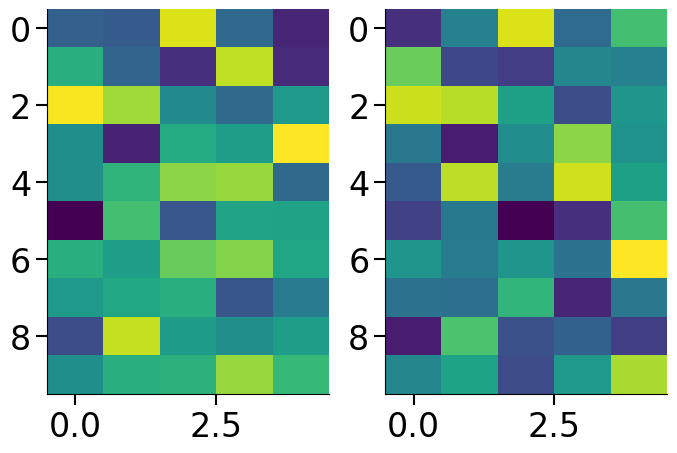

In [73]:
fig,axs = plt.subplots(1,2,figsize=(8,5))
im0 = axs[0].imshow(cca_pb.x_weights_,aspect='auto')
im1 = axs[1].imshow(cca_tr.x_weights_,aspect='auto')

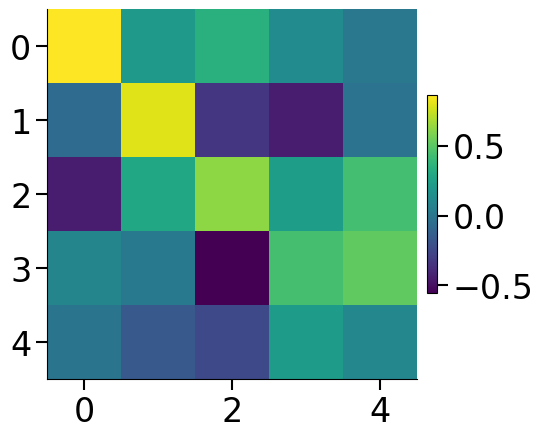

In [74]:
plt.imshow(cca_pb.x_weights_.T@cca_tr.x_weights_)

plt.colorbar(orientation='vertical', fraction=0.02, pad=0.02)

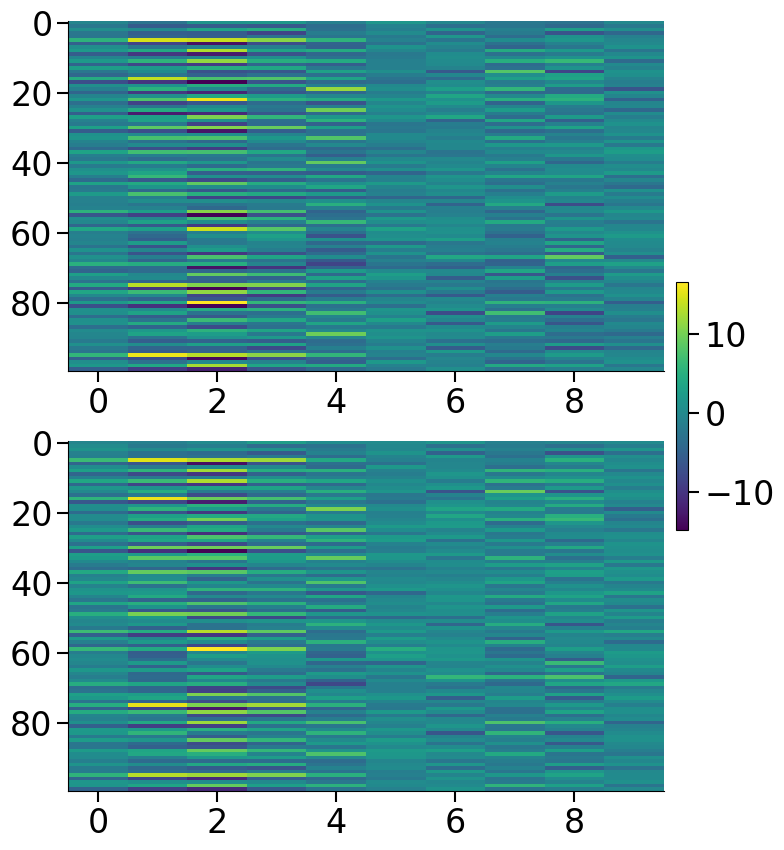

In [66]:
fig,axs = plt.subplots(2,1,figsize=(8,10))
im0 = axs[0].imshow(A_tr[300:400,],aspect='auto')
im1 = axs[1].imshow(A_pb[300:400,],aspect='auto')

fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)

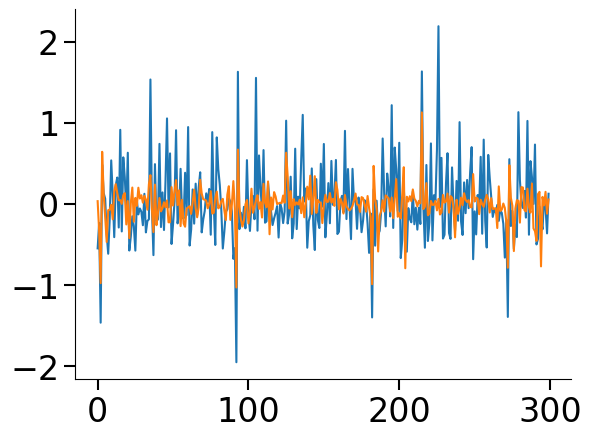

In [67]:
plt.plot(A_c[:300,0])
plt.plot(P_c[:300,0])

In [12]:
cca.x_weights_.T

array([[-0.07139877, -0.28440047,  0.722223  ,  0.07837949,  0.08133246,
        -0.51417526, -0.02505625, -0.06930343, -0.29500732, -0.15105602],
       [-0.49804842,  0.65181776,  0.28299734, -0.32679121, -0.34450281,
         0.06785484,  0.00433471, -0.08510166, -0.05315297, -0.08263538],
       [ 0.26327412, -0.29846246,  0.37965918, -0.4391052 , -0.32991026,
         0.32691836,  0.10362167,  0.47427599,  0.18563907,  0.1371095 ],
       [-0.25344522,  0.09523215,  0.03247808,  0.41900747, -0.08078769,
        -0.20285653, -0.45869465,  0.59051727,  0.37748319,  0.02814027],
       [-0.50535424, -0.22670414,  0.15514866, -0.20029837,  0.55559418,
         0.21912824, -0.07687169, -0.14425775,  0.26456185,  0.41906703]])

In [13]:
cca.x_weights_.T@cca.x_weights_

array([[ 1.00000000e+00,  1.86212722e-15, -1.41926441e-15,
        -1.59487238e-16, -6.96850026e-16],
       [ 1.86212722e-15,  1.00000000e+00,  1.94906952e-16,
        -4.14902265e-17,  3.28780259e-16],
       [-1.41926441e-15,  1.94906952e-16,  1.00000000e+00,
        -1.30448087e-15,  1.84024100e-16],
       [-1.59487238e-16, -4.14902265e-17, -1.30448087e-15,
         1.00000000e+00,  4.62586507e-16],
       [-6.96850026e-16,  3.28780259e-16,  1.84024100e-16,
         4.62586507e-16,  1.00000000e+00]])

In [75]:
#cca_pc_a1 = pca_a1.transform(standardize(cca.x_weights_.T)).T
#cca_pc_pmc = pca_pmc.transform(standardize(cca.y_weights_.T)).T
cca_pc_a1 = cca_pb.x_weights_
cca_pc_pmc = cca_pb.y_weights_

with open("Save/CCA_a1_1000-5000_pb", "wb") as fp:   # Unpickling
     pickle.dump(cca_pc_a1, fp)

with open("Save/CCA_pmc_1000-5000_pb", "wb") as fp:   # Unpickling
     pickle.dump(cca_pc_pmc, fp)

In [252]:
def variance_explained_by_subspace(W, X):
    """
    Compute variance explained by a subspace and its orthogonal complement.

    Parameters
    ----------
    W : ndarray, shape (n_features, n_components)
        CCA weight matrix (columns are subspace basis vectors).
    X : ndarray, shape (n_samples, n_features)
        Data matrix.

    Returns
    -------
    var_in_subspace : float
        Fraction of total variance explained by the CCA subspace.
    var_in_complement : float
        Fraction of total variance in the orthogonal complement.
    """
    Q, _ = np.linalg.qr(W)  # Q spans the same subspace as W

    # Project data into subspace
    X_proj = X @ Q @ Q.T   

    # Residual (orthogonal complement)
    X_resid = X - X_proj

    # Total variance
    total_var = np.sum(np.var(X, axis=0, ddof=1))

    # Variance in subspace
    var_subspace = np.sum(np.var(X_proj, axis=0, ddof=1))
    var_complement = np.sum(np.var(X_resid, axis=0, ddof=1))

    return var_subspace / total_var, var_complement / total_var

print(variance_explained_by_subspace(pca_a1.transform(cca.x_weights_.T).T, pca_a1.transform(A_pb)))
print(variance_explained_by_subspace(pca_a1.transform(cca.x_weights_.T).T, pca_a1.transform(A_tr)))

print(variance_explained_by_subspace(pca_pmc.transform(cca.y_weights_.T).T, pca_pmc.transform(P_pb)))
print(variance_explained_by_subspace(pca_pmc.transform(cca.y_weights_.T).T, pca_pmc.transform(P_tr)))

(0.2741254809836381, 0.725874519016361)
(0.28210038957281647, 0.7178996104271833)
(0.3638356111360868, 0.6361643888639135)
(0.35285764609166564, 0.6471423539083355)


In [15]:
print(np.std(P_pb,axis=0))
print(np.std(P_tr,axis=0))

"""
print(np.std(P_pb,axis=0))
print(np.std(P_tr,axis=0))
"""

[5.92269117 5.71898405 3.66920797 5.22153609 2.54266607 2.32501703
 2.80663327 2.08750934 3.35681203 2.24500478]
[5.88777594 5.7118662  3.80958728 4.95646464 2.69545728 2.27684016
 2.71302759 1.95606623 3.36638896 2.35857963]


'\nprint(np.std(P_pb,axis=0))\nprint(np.std(P_tr,axis=0))\n'

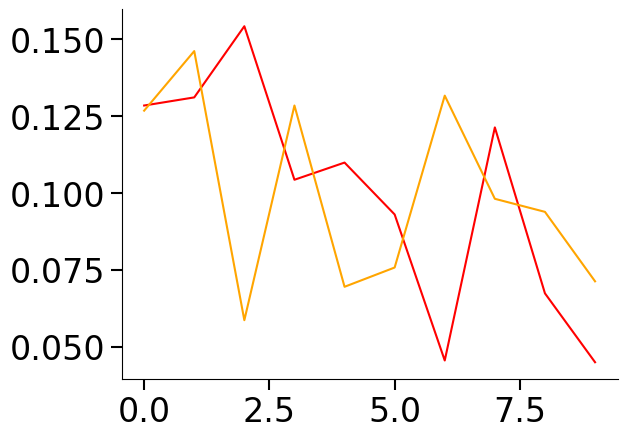

In [55]:
plt.plot(np.mean((cca.x_weights_.T)**2,axis=0),color='red')
plt.plot(np.mean((cca.y_weights_.T)**2,axis=0),color='orange')

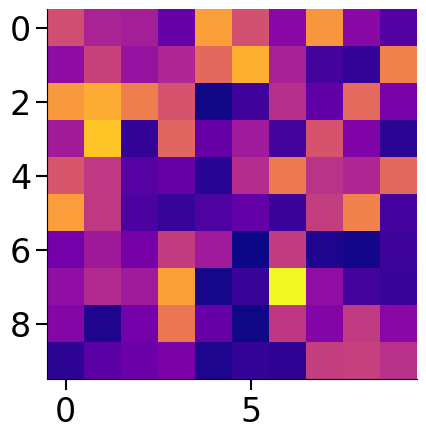

In [17]:
plt.imshow(np.abs(cca.x_weights_@cca.y_weights_.T),cmap='plasma')